In [16]:
import os
from tqdm import tqdm
import numpy as np 
import pandas as pd
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import json
import tensorflow as tf
import tensorflow_probability
from tensorflow_probability import distributions as tfd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


#preprocess.
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import RandomRotation

# specifically for cnn
from efficientnet.tfkeras import EfficientNetB0
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback

In [ ]:
# Load class names
with open("food-101/meta/classes.txt", "r") as file:
    classes = [line.strip() for line in file]

# Read image paths
with open("food-101/meta/train.txt", "r") as file:
    train_paths = [line.strip() for line in file]

with open("food-101/meta/test.txt", "r") as file:
    test_paths = [line.strip() for line in file]

def to_snake_case(name):
    return name.replace(" ", "_").lower()

train_full_paths = [os.path.join("food-101/images", p + ".jpg") for p in train_paths]
train_labels = [to_snake_case(p.split("/")[0]) for p in train_paths]

test_full_paths = [os.path.join("food-101/images", p + ".jpg") for p in test_paths]
test_labels = [to_snake_case(p.split("/")[0]) for p in test_paths]

class_to_index = {cls: idx for idx, cls in enumerate(classes)}
train_label_indices = [class_to_index[label] for label in train_labels]
test_label_indices = [class_to_index[label] for label in test_labels]

print(class_to_index)

# Split 80% train, 20% val
train_paths_split, val_paths_split, train_labels_split, val_labels_split = train_test_split(
    train_full_paths, train_label_indices, test_size=0.2, stratify=train_label_indices, random_state=42
)

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = len(classes)

rotation_layer = RandomRotation(factor=0.014)

def augment_image(img):
    img = rotation_layer(img) 
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.image.random_crop(img, size=[224, 224, 3])
    img = tf.image.random_flip_left_right(img)

    img = tf.image.random_brightness(img, max_delta=0.1)         
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)    
    img = tf.image.random_saturation(img, lower=0.95, upper=1.05) 
    img = tf.image.random_hue(img, max_delta=0.05)                

    img = tf.clip_by_value(img, 0.0, 255.0)
    return img

def process_example(path, label, augment=False):
    img_raw = tf.io.read_file(path)
    
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if augment:
        img = augment_image(img)
    img = preprocess_input(img)
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

def create_dataset(paths, labels, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(lambda x, y: process_example(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

val_ds = create_dataset(val_paths_split, val_labels_split, augment=False, shuffle=False)
test_ds = create_dataset(test_full_paths, test_label_indices, shuffle=False)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [ ]:
# Internet Dataset
test_internet_full_paths = []
test_internet_labels = []

for i in range(len(classes)):
    for j in range(len(os.listdir("Internet-Dataset/dataset/" + classes[i]))):
        test_internet_full_paths.append(os.path.join("Internet-Dataset/dataset", classes[i], f"{j+1:02d}.png"))
        test_internet_labels.append(to_snake_case(classes[i]))
        

class_to_index = {cls: idx for idx, cls in enumerate(classes)}
test_internet_label_indices = [class_to_index[label] for label in test_internet_labels]

print(class_to_index)

def process_png(path, label):
    img_raw = tf.io.read_file(path)
    
    img = tf.image.decode_png(img_raw, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

def create_dataset_internet(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(lambda x, y: process_png(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

internet_test_ds = create_dataset_internet(test_internet_full_paths, test_internet_label_indices, shuffle=False)


{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [10]:
from PIL import Image
import imghdr, os

for path in test_internet_full_paths:
    fmt = imghdr.what(path)
    if fmt != "png":
        try:
            img = Image.open(path).convert("RGB")
            img.save(path, "PNG")
            print(f"Converted {path} from {fmt} to PNG")
        except Exception as e:
            print(f"Could not convert {path}: {e}")

In [9]:
for path in test_internet_full_paths:
    if imghdr.what(path) not in ["png"]:
        print("Problem file:", path, imghdr.what(path))

In [4]:
#FoodX-251 Load Dataset

foodx_classes = {}
with open("FoodX-251/class_list.txt", "r") as file:
    for line in file:
        idx, name = line.strip().split()
        foodx_classes[int(idx)] = name

mapping = {}
for fx_idx, fx_name in foodx_classes.items():
    if fx_name in classes:
        mapping[fx_idx] = classes.index(fx_name)
    else:
        mapping[fx_idx] = None  # no direct match

print(mapping)

foodx_val_labels_df = pd.read_csv("FoodX-251/val_labels.csv")
foodx_train_labels_df = pd.read_csv("FoodX-251/train_labels.csv")
foodx_test_paths = []
foodx_test_labels = []

def process_example(path, label):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    label = tf.one_hot(label, 101)
    return img, label

for idx, row in foodx_val_labels_df.iterrows():
    img_path = os.path.join("FoodX-251/val_set", row['img_name'])
    foodx_label = row['label']
    if mapping[foodx_label] is not None:
        foodx_test_paths.append(img_path)
        foodx_test_labels.append(mapping[foodx_label])

# for idx, row in foodx_train_labels_df.iterrows():
#     img_path = os.path.join("FoodX-251/train_set", row['img_name'])
#     foodx_label = row['label']
#     if mapping[foodx_label] is not None:
#         foodx_test_paths.append(img_path)
#         foodx_test_labels.append(mapping[foodx_label])

foodx_test_ds =  tf.data.Dataset.from_tensor_slices((foodx_test_paths, foodx_test_labels))
foodx_test_ds = foodx_test_ds.map(process_example, num_parallel_calls=tf.data.AUTOTUNE)
foodx_test_ds = foodx_test_ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

{0: 63, 1: 6, 2: None, 3: None, 4: 85, 5: 98, 6: None, 7: None, 8: 32, 9: 86, 10: None, 11: None, 12: None, 13: None, 14: None, 15: 88, 16: None, 17: None, 18: 4, 19: 12, 20: 39, 21: None, 22: None, 23: 70, 24: 78, 25: 81, 26: 80, 27: 7, 28: None, 29: 0, 30: 84, 31: None, 32: None, 33: None, 34: None, 35: None, 36: None, 37: 95, 38: None, 39: None, 40: 66, 41: None, 42: None, 43: 92, 44: None, 45: None, 46: None, 47: None, 48: None, 49: 30, 50: 35, 51: 25, 52: 14, 53: 36, 54: None, 55: None, 56: None, 57: 47, 58: None, 59: None, 60: 13, 61: None, 62: 27, 63: None, 64: None, 65: 87, 66: None, 67: None, 68: 21, 69: None, 70: 90, 71: None, 72: None, 73: 2, 74: None, 75: None, 76: 33, 77: None, 78: None, 79: 62, 80: None, 81: 46, 82: 5, 83: None, 84: None, 85: None, 86: 72, 87: None, 88: 68, 89: 83, 90: None, 91: None, 92: 18, 93: 20, 94: 11, 95: None, 96: 57, 97: 38, 98: 59, 99: None, 100: None, 101: None, 102: 26, 103: None, 104: 74, 105: 51, 106: None, 107: None, 108: 96, 109: 94, 110: 

In [5]:
def get_cosine_annealing_with_restarts(
    initial_lr=1e-3,
    min_lr=1e-7,
    warmup_epochs=5,
    T_0=20,
    T_mult=1
):
    def scheduler(epoch, lr):

        # Warmup phase
        if epoch < warmup_epochs:
            return float(initial_lr * (epoch + 1) / warmup_epochs)

        # Cosine annealing with restarts
        t = epoch - warmup_epochs  # Epochs after warmup
        T_i = T_0
        cumulative = 0

        while t >= T_i:
            t -= T_i
            cumulative += T_i
            T_i *= T_mult

        progress = t / T_i
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        return float(min_lr + (initial_lr - min_lr) * cosine_decay)

    return scheduler

def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    image1, image2 = images, tf.gather(images, indices)
    label1, label2 = labels, tf.gather(labels, indices)

    h = tf.shape(images)[1]
    w = tf.shape(images)[2]
    lam = tfd.Beta(alpha, alpha).sample()

    cut_rat = tf.math.sqrt(1. - lam)
    cut_w = tf.cast(tf.cast(w, tf.float32) * cut_rat, tf.int32)
    cut_h = tf.cast(tf.cast(h, tf.float32) * cut_rat, tf.int32)

    cx = tf.random.uniform([], 0, w, dtype=tf.int32)
    cy = tf.random.uniform([], 0, h, dtype=tf.int32)

    x1 = tf.clip_by_value(cx - cut_w // 2, 0, w)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, h)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, w)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, h)

    def replace_patch(img1, img2):
        patch = img2[y1:y2, x1:x2, :]
        paddings = [[y1, h - y2], [x1, w - x2], [0, 0]]
        patch_padded = tf.pad(patch, paddings)
        mask = tf.pad(tf.ones_like(patch), paddings)
        return tf.where(mask > 0, patch_padded, img1)

    mixed_images = tf.map_fn(lambda x: replace_patch(x[0], x[1]), (image1, image2), dtype=tf.float32)

    patch_area = tf.cast((x2 - x1) * (y2 - y1), tf.float32)
    total_area = tf.cast(h * w, tf.float32)
    lam_adjusted = 1.0 - (patch_area / total_area)

    mixed_labels = lam_adjusted * label1 + (1.0 - lam_adjusted) * label2

    return mixed_images, mixed_labels

def apply_cutmix(ds):
    return ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)

def mixup(images, labels, alpha=0.5):
        batch_size = tf.shape(images)[0]
        indices = tf.random.shuffle(tf.range(batch_size))
        image1, image2 = images, tf.gather(images, indices)
        label1, label2 = labels, tf.gather(labels, indices)

        lam = tfd.Beta(alpha, alpha).sample()
        lam_x = tf.reshape(lam, [1, 1, 1])
        lam_y = tf.reshape(lam, [1])

        mixed_image = lam_x * image1 + (1 - lam_x) * image2
        mixed_label = lam_y * label1 + (1 - lam_y) * label2

        return mixed_image, mixed_label

def apply_mixup(ds):
    return ds.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)

def apply_mixup_cutmix(ds, alpha_mixup=0.5, alpha_cutmix=1.0):
    counter = tf.data.experimental.Counter()  # will increment per batch
    mixed_ds = tf.data.Dataset.zip((counter, ds)).map(
        lambda i, data: tf.cond(
            tf.equal(i % 2, 0),
            lambda: mixup(data[0], data[1], alpha=alpha_mixup),   # Even → MixUp
            lambda: cutmix(data[0], data[1], alpha=alpha_cutmix)   # Odd → CutMix
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return mixed_ds

In [6]:
def add_gaussian_noise(img, mean=0.0, stddev=25.0):
    noise = tf.random.normal(shape=tf.shape(img), mean=mean, stddev=stddev, dtype=tf.float32)
    img = tf.cast(img, tf.float32) + noise
    img = tf.clip_by_value(img, 0.0, 255.0)  # keep pixel range
    return img


def apply_gaussian_noise(img, label):
    return add_gaussian_noise(img), label

test_ds_gaussian = test_ds.map(apply_gaussian_noise)

In [7]:
def _erase_one_image(x, p=0.5, sl=0.02, sh=0.4, r1=0.3, random_fill=True):
    def _apply(img):
        h = tf.shape(img)[0]; w = tf.shape(img)[1]; c = tf.shape(img)[2]
        area = tf.cast(h * w, tf.float32)

        target_area = tf.random.uniform([], sl, sh) * area
        aspect = tf.random.uniform([], r1, 1.0 / r1)

        eh = tf.cast(tf.round(tf.sqrt(target_area * aspect)), tf.int32)
        ew = tf.cast(tf.round(tf.sqrt(target_area / aspect)), tf.int32)
        eh = tf.clip_by_value(eh, 1, h); ew = tf.clip_by_value(ew, 1, w)

        x1 = tf.random.uniform([], 0, h - eh + 1, dtype=tf.int32)
        y1 = tf.random.uniform([], 0, w - ew + 1, dtype=tf.int32)

        pad = [[x1, h - (x1 + eh)], [y1, w - (y1 + ew)], [0, 0]]
        mask1 = tf.pad(tf.ones([eh, ew, 1], img.dtype), pad)     
        mask  = tf.broadcast_to(mask1, [h, w, c])                   

        if random_fill:
            vmin = tf.reduce_min(img); vmax = tf.reduce_max(img)
            fill1 = tf.pad(tf.random.uniform([eh, ew, 1], vmin, vmax, dtype=img.dtype), pad)
        else:
            gray = tf.reduce_mean(img)  
            fill1 = tf.pad(tf.fill([eh, ew, 1], tf.cast(gray, img.dtype)), pad)
        fill = tf.broadcast_to(fill1, [h, w, c])

        return img * (1.0 - mask) + fill * mask

    return tf.cond(tf.random.uniform([]) < p, lambda: _apply(x), lambda: x)

def apply_random_erasing_batched(ds, p=1.0, sl=0.02, sh=0.4, r1=0.3, n=1, random_fill=True):
    def _erase_n(img):
        def body(i, im):
            im = _erase_one_image(im, p=p, sl=sl, sh=sh, r1=r1, random_fill=random_fill)
            return i+1, im
        _, out = tf.while_loop(lambda i, *_: i < n, body, (0, img))
        return out

    def _map_fn(images, labels):
        if images.dtype == tf.uint8:
            images = tf.image.convert_image_dtype(images, tf.float32) 
        else:
            images = tf.cast(images, tf.float32)

        images = tf.map_fn(_erase_n, images, fn_output_signature=tf.float32)
        return images, labels

    return ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
def gaussian_kernel(size: int, sigma: float):
    # 2D separable kernel
    x = tf.range(-size//2 + 1, size//2 + 1, dtype=tf.float32)
    g = tf.exp(-(x**2)/(2.0*sigma**2))
    g = g / tf.reduce_sum(g)
    g_col = tf.reshape(g, [size, 1, 1, 1])
    g_row = tf.reshape(g, [1, size, 1, 1])
    return g_col, g_row

def blur_image(img, sigma):
    # img: float32 [H,W,3] in [0,1]
    k = max(3, int(2*round(4*sigma)+1))
    g_col, g_row = gaussian_kernel(k, sigma)
    img = tf.expand_dims(img, 0)
    # depthwise conv per channel
    img = tf.nn.depthwise_conv2d(img, tf.tile(g_col, [1,1,3,1]), strides=[1,1,1,1], padding="SAME")
    img = tf.nn.depthwise_conv2d(img, tf.tile(g_row, [1,1,3,1]), strides=[1,1,1,1], padding="SAME")
    return tf.clip_by_value(tf.squeeze(img, 0), 0.0, 1.0)

def add_blur_pipeline(ds, sigma):
    return (ds
            .map(lambda x,y: (blur_image(tf.image.convert_image_dtype(x, tf.float32), sigma), y),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x,y: (tf.image.convert_image_dtype(x, tf.uint8), y),
                 num_parallel_calls=tf.data.AUTOTUNE))

In [19]:
blur_test_ds = add_blur_pipeline(test_ds, sigma=2.0)


ValueError: in user code:

    File "C:\Users\joeln\AppData\Local\Temp\ipykernel_1684\368507844.py", line 22, in None  *
        lambda x,y: (blur_image(tf.image.convert_image_dtype(x, tf.float32), sigma), y)
    File "C:\Users\joeln\AppData\Local\Temp\ipykernel_1684\368507844.py", line 16, in blur_image  *
        img = tf.nn.depthwise_conv2d(img, tf.tile(g_col, [1,1,3,1]), strides=[1,1,1,1], padding="SAME")

    ValueError: Shape must be rank 4 but is rank 5 for '{{node depthwise}} = DepthwiseConv2dNative[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="SAME", strides=[1, 1, 1, 1]](ExpandDims, Tile)' with input shapes: [1,?,224,224,3], [17,1,3,1].


In [8]:
def load_dataset_lossless(images_dir, labels_csv, batch_size=64):
    df = pd.read_csv(labels_csv)
    file_paths = [os.path.join(images_dir, fname) for fname in df.iloc[:, 0]]
    labels = df.iloc[:, 1:].values

    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels.astype("float32")))

    def load_and_preprocess(path, label):
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_png(img_raw, channels=3)  # exact pixels back
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = preprocess_input(img)  # SAME preprocessing as in your original pipeline
        return img, label

    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [9]:
def show_batch(dataset, class_names, title="Training Batch"):
    for images, labels in dataset.take(3):  # Take one batch
        batch_size = images.shape[0]
        plt.figure(figsize=(16, batch_size // 8 * 2))  # Adjust height dynamically
        for i in range(batch_size):
            ax = plt.subplot(batch_size // 8, 8, i + 1)  # 8 columns
            img = images[i].numpy().astype("uint8")
            label_index = tf.argmax(labels[i]).numpy()
            plt.imshow(img)
            plt.title(class_names[label_index], fontsize=8)
            plt.axis("off")
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

def show_batch_cutmix(dataset, class_names, title="Training Batch"):
    plt.figure(figsize=(14, 10))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(12):  # Show 12 images
            ax = plt.subplot(3, 4, i + 1)
            img = images[i].numpy().astype("uint8")
            label = labels[i].numpy()

            # Get top two label indices and their corresponding weights
            top2_idx = label.argsort()[-2:][::-1]
            top1_idx, top2_idx = top2_idx[0], top2_idx[1]
            top1_prob, top2_prob = label[top1_idx], label[top2_idx]

            top1_name = class_names[top1_idx]
            top2_name = class_names[top2_idx]

            # Convert to percentages
            top1_percent = round(100 * top1_prob, 1)
            top2_percent = round(100 * top2_prob, 1)

            title_text = f"{top1_name} ({top1_percent}%)\n{top2_name} ({top2_percent}%)"
            plt.imshow(img)
            plt.title(title_text, fontsize=9)
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [15]:
test_ds_gaussian = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/gaussian_noise", "C:/Documents/Research/skripsi/test_dataset/gaussian_noise/gaussian_noise_test_labels.csv")

cutmix_model = load_model("C:/Documents/Research/skripsi/model/cutmix_2_model_efficientnet.keras")

cutmix_model.evaluate(test_ds_gaussian, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 327s 819ms/step - accuracy: 0.6370 - loss: 1.7279 - top_5_accuracy: 0.8669


[1.6701862812042236, 0.6531881093978882, 0.8747326731681824]

In [148]:
# No Augmentation
train_ds = create_dataset(train_paths_split, train_labels_split, augment=False)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/baseline_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/baseline_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)


Epoch 1/5


KeyboardInterrupt: 

In [ ]:
#Basic Augmentation
train_ds = create_dataset(train_paths_split, train_labels_split, augment=True)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/basic_augmentation_2_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/basic_augmentation_2_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)


Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.1778 - loss: 3.8017 - top_5_accuracy: 0.3780
Epoch 1: val_accuracy improved from -inf to 0.51135, saving model to C:/Documents/Research/skripsi/model/basic_augmentation_2_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 964s 1s/step - accuracy: 0.1780 - loss: 3.8010 - top_5_accuracy: 0.3782 - val_accuracy: 0.5114 - val_loss: 2.2415 - val_top_5_accuracy: 0.7796 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.4628 - loss: 2.3973 - top_5_accuracy: 0.7460
Epoch 2: val_accuracy improved from 0.51135 to 0.58449, saving model to C:/Documents/Research/skripsi/model/basic_augmentation_2_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 961s 1s/step - accuracy: 0.4628 - loss: 2.3972 - top_5_accuracy: 0.7460 - val_accuracy: 0.5845 - val_loss: 1.9385 - val_top_5_accuracy: 0.8349 - learning_rate: 4.0000e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.5253

In [125]:
# Mixup Augmentation
train_ds_mixup = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_mixup = apply_mixup(train_ds_mixup, alpha=0.5)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/mixup_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_mixup, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_mixup,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/mixup_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.1416 - loss: 4.1137 - top_5_accuracy: 0.3168
Epoch 1: val_accuracy improved from -inf to 0.49228, saving model to C:/Documents/Research/skripsi/model/mixup_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 986s 1s/step - accuracy: 0.1417 - loss: 4.1133 - top_5_accuracy: 0.3170 - val_accuracy: 0.4923 - val_loss: 2.3862 - val_top_5_accuracy: 0.7692 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.3980 - loss: 3.0983 - top_5_accuracy: 0.6706
Epoch 2: val_accuracy improved from 0.49228 to 0.57366, saving model to C:/Documents/Research/skripsi/model/mixup_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 935s 987ms/step - accuracy: 0.3980 - loss: 3.0983 - top_5_accuracy: 0.6706 - val_accuracy: 0.5737 - val_loss: 1.9994 - val_top_5_accuracy: 0.8323 - learning_rate: 4.0000e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.4482 - loss: 2.9536 - top_5_acc

In [156]:
# Cutmix Augmentation
train_ds_cutmix = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_cutmix = apply_cutmix(train_ds_mixup, alpha=1.0)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/cutmix_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_cutmix, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_cutmix,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/cutmix_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.0782 - loss: 4.4320 - top_5_accuracy: 0.1994
Epoch 1: val_accuracy improved from -inf to 0.43564, saving model to C:/Documents/Research/skripsi/model/cutmix_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 1079s 1s/step - accuracy: 0.0783 - loss: 4.4317 - top_5_accuracy: 0.1995 - val_accuracy: 0.4356 - val_loss: 2.7696 - val_top_5_accuracy: 0.7197 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.2347 - loss: 3.8876 - top_5_accuracy: 0.4707
Epoch 2: val_accuracy improved from 0.43564 to 0.51492, saving model to C:/Documents/Research/skripsi/model/cutmix_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 1008s 1s/step - accuracy: 0.2347 - loss: 3.8876 - top_5_accuracy: 0.4707 - val_accuracy: 0.5149 - val_loss: 2.3163 - val_top_5_accuracy: 0.7774 - learning_rate: 4.0000e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.2879 - loss: 3.7415 - top_5_ac

In [174]:
# Mixup and Cutmix Augmentation
train_ds_mixup_cutmix = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_mixup_cutmix = apply_mixup_cutmix(train_ds_mixup_cutmix)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/mixup_cutmix_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_mixup_cutmix, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_mixup_cutmix,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/mixup_cutmix_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.1343 - loss: 4.1483 - top_5_accuracy: 0.3015
Epoch 1: val_accuracy improved from -inf to 0.48766, saving model to C:/Documents/Research/skripsi/model/mixup_cutmix_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 1022s 1s/step - accuracy: 0.1344 - loss: 4.1478 - top_5_accuracy: 0.3017 - val_accuracy: 0.4877 - val_loss: 2.4220 - val_top_5_accuracy: 0.7686 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.3540 - loss: 3.2560 - top_5_accuracy: 0.6194
Epoch 2: val_accuracy improved from 0.48766 to 0.56693, saving model to C:/Documents/Research/skripsi/model/mixup_cutmix_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - accuracy: 0.3540 - loss: 3.2559 - top_5_accuracy: 0.6195 - val_accuracy: 0.5669 - val_loss: 2.0456 - val_top_5_accuracy: 0.8224 - learning_rate: 4.0000e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.4126 - loss: 3.0501

In [23]:
# Mixup with Alpha 1.0
train_ds_mixup = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_mixup = apply_mixup(train_ds_mixup)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/mixup_alpha_1_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_mixup, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_mixup,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/mixup_alpha_1_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.1337 - loss: 4.1942 - top_5_accuracy: 0.2971
Epoch 1: val_accuracy improved from -inf to 0.49010, saving model to C:/Documents/Research/skripsi/model/mixup_alpha_1_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 1020s 1s/step - accuracy: 0.1338 - loss: 4.1938 - top_5_accuracy: 0.2973 - val_accuracy: 0.4901 - val_loss: 2.4645 - val_top_5_accuracy: 0.7650 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.3540 - loss: 3.3810 - top_5_accuracy: 0.6218
Epoch 2: val_accuracy improved from 0.49010 to 0.56337, saving model to C:/Documents/Research/skripsi/model/mixup_alpha_1_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 945s 997ms/step - accuracy: 0.3540 - loss: 3.3809 - top_5_accuracy: 0.6218 - val_accuracy: 0.5634 - val_loss: 2.0866 - val_top_5_accuracy: 0.8207 - learning_rate: 4.0000e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.4207 - loss: 3

In [33]:
# Mixup and Cutmix Augmentation Part 2
train_ds_mixup_cutmix = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_mixup_cutmix = apply_mixup_cutmix(train_ds_mixup_cutmix, alpha_mixup=0.5)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/mixup_cutmix_alpha_05_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_mixup_cutmix, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_mixup_cutmix,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/mixup_cutmix_alpha_05_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use fn_output_signature instead
Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.1235 - loss: 4.1890 - top_5_accuracy: 0.2854
Epoch 1: val_accuracy improved from -inf to 0.48977, saving model to C:/Documents/Research/skripsi/model/mixup_cutmix_alpha_05_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 991s 1s/step - accuracy: 0.1236 - loss: 4.1886 - top_5_accuracy: 0.2856 - val_accuracy: 0.4898 - val_loss: 2.4421 - val_top_5_accuracy: 0.7694 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.3476 - loss: 3.2960 - top_5_accuracy: 0.6172
Epoch 2: val_accuracy improved from 0.48977 to 0.56838, saving model to C:/Documents/Research/skripsi/model/mixup_cutmix_alpha_05_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 980s 1s/step - accuracy: 0.3476 - loss: 3.2959 - top_5_accuracy: 0.6173 - val_accuracy: 0.5684 - val_loss: 2.0

In [ ]:
#50% Augmented Images, 50% Clean Images
train_paths_aug, train_paths_clean, train_labels_aug, train_labels_clean = train_test_split(
    train_paths_split,
    train_labels_split,
    test_size=0.5, 
    stratify=train_labels_split,
    random_state=42
)

train_ds_aug = create_dataset(train_paths_aug, train_labels_aug, augment=True, shuffle=False)
train_ds_clean = create_dataset(train_paths_clean, train_labels_clean, augment=False, shuffle=False)

train_ds_combined = train_ds_aug.concatenate(train_ds_clean)
train_ds_combined = train_ds_combined.shuffle(buffer_size=len(train_paths_split))

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/augment_clean_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_combined, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_combined,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/augment_clen_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Epoch 1/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.2028 - loss: 3.7260 - top_5_accuracy: 0.4041
Epoch 1: val_accuracy improved from -inf to 0.52046, saving model to C:/Documents/Research/skripsi/model/augment_clean_model_efficientnet.keras
948/948 ━━━━━━━━━━━━━━━━━━━━ 1059s 1s/step - accuracy: 0.2029 - loss: 3.7253 - top_5_accuracy: 0.4043 - val_accuracy: 0.5205 - val_loss: 2.1967 - val_top_5_accuracy: 0.7908 - learning_rate: 2.0000e-04
Epoch 2/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.4794 - loss: 2.3169 - top_5_accuracy: 0.7629
Epoch 2: val_accuracy improved from 0.52046 to 0.59657, saving model to C:/Documents/Research/skripsi/model/augment_clean_model_efficientnet.keras
948/948 ━━━━━━━━━━━━━━━━━━━━ 1116s 1s/step - accuracy: 0.4794 - loss: 2.3169 - top_5_accuracy: 0.7629 - val_accuracy: 0.5966 - val_loss: 1.9019 - val_top_5_accuracy: 0.8426 - learning_rate: 4.0000e-04
Epoch 3/5
948/948 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.5415 - loss: 2.0

: 

In [28]:
# Cutmix Augmentation
train_ds_cutmix = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_cutmix = apply_cutmix(train_ds_cutmix)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)

base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='C:/Documents/Research/skripsi/model/cutmix_2_model_efficientnet.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds_cutmix, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds_cutmix,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/cutmix_2_history_efficientnet.json', 'w') as f:
    json.dump(combined_history, f)

Instructions for updating:
Use fn_output_signature instead
Epoch 1/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.1156 - loss: 4.2338 - top_5_accuracy: 0.2681
Epoch 1: val_accuracy improved from -inf to 0.47050, saving model to C:/Documents/Research/skripsi/model/cutmix_2_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 991s 1s/step - accuracy: 0.1157 - loss: 4.2334 - top_5_accuracy: 0.2683 - val_accuracy: 0.4705 - val_loss: 2.5165 - val_top_5_accuracy: 0.7496 - learning_rate: 2.0000e-04
Epoch 2/5
947/947 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.3014 - loss: 3.4744 - top_5_accuracy: 0.5592
Epoch 2: val_accuracy improved from 0.47050 to 0.55505, saving model to C:/Documents/Research/skripsi/model/cutmix_2_model_efficientnet.keras
947/947 ━━━━━━━━━━━━━━━━━━━━ 950s 1s/step - accuracy: 0.3014 - loss: 3.4744 - top_5_accuracy: 0.5593 - val_accuracy: 0.5550 - val_loss: 2.1356 - val_top_5_accuracy: 0.8098 - learning_rate: 4.0000e-04
Epoch 3/5
947/947 ━━━━━━━━━━━━━━━━━━

In [30]:
test_ds = create_dataset(test_full_paths, test_label_indices, shuffle=False)

In [31]:
test_ds_augmented = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/augmented", "C:/Documents/Research/skripsi/test_dataset/augmented/augmented_test_labels.csv")
test_ds_gaussian = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/gaussian_noise", "C:/Documents/Research/skripsi/test_dataset/gaussian_noise/gaussian_noise_test_labels.csv")
test_ds_random_erasing = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/random_erasing", "C:/Documents/Research/skripsi/test_dataset/random_erasing/random_erasing_test_labels.csv")

with open('skripsi/result/clean/result_cutmix_2.json', 'w') as f:
    json.dump(model_cutmix_2.evaluate(test_ds), f)
with open('skripsi/result/augmented/result_cutmix_2.json', 'w') as f:
    json.dump(model_cutmix_2.evaluate(test_ds_augmented), f)
with open('skripsi/result/gaussian_noise/result_cutmix_2.json', 'w') as f:
    json.dump(model_cutmix_2.evaluate(test_ds_gaussian), f)
with open('skripsi/result/random_erasing/result_cutmix_2.json', 'w') as f:
    json.dump(model_cutmix_2.evaluate(test_ds_random_erasing), f)

395/395 ━━━━━━━━━━━━━━━━━━━━ 309s 773ms/step - accuracy: 0.8233 - loss: 1.0598 - top_5_accuracy: 0.9590
395/395 ━━━━━━━━━━━━━━━━━━━━ 291s 737ms/step - accuracy: 0.7790 - loss: 1.2176 - top_5_accuracy: 0.9409
395/395 ━━━━━━━━━━━━━━━━━━━━ 291s 737ms/step - accuracy: 0.6370 - loss: 1.7279 - top_5_accuracy: 0.8669
395/395 ━━━━━━━━━━━━━━━━━━━━ 290s 735ms/step - accuracy: 0.7062 - loss: 1.5557 - top_5_accuracy: 0.8848


In [12]:
model_baseline = load_model('C:/Documents/Research/skripsi/model/baseline_model_efficientnet.keras')
model_augmented = load_model('C:/Documents/Research/skripsi/model/basic_augmentation_2_model_efficientnet.keras')
model_mixup = load_model('C:/Documents/Research/skripsi/model/mixup_model_efficientnet.keras')
model_mixup_alpha_1 = load_model('C:/Documents/Research/skripsi/model/mixup_alpha_1_model_efficientnet.keras')
model_cutmix = load_model('C:/Documents/Research/skripsi/model/cutmix_model_efficientnet.keras')
model_mixup_cutmix = load_model('C:/Documents/Research/skripsi/model/mixup_cutmix_model_efficientnet.keras')
model_mixup_cutmix_alpha_05 = load_model('C:/Documents/Research/skripsi/model/mixup_cutmix_alpha_05_model_efficientnet.keras')
model_augment_clean = load_model('C:/Documents/Research/skripsi/model/augment_clean_model_efficientnet.keras')
model_cutmix_2 = load_model("C:/Documents/Research/skripsi/model/cutmix_2_model_efficientnet.keras")

In [11]:
mobilenet_model_baseline = load_model('C:/Documents/Research/skripsi/model/Baseline_Model_MobilenetV3.keras')
mobilenet_model_augmented = load_model('C:/Documents/Research/skripsi/model/Basic_Augmentation_Model_MobilenetV3.keras')
mobilenet_model_mixup = load_model('C:/Documents/Research/skripsi/model/Mixup_Model_MobilenetV3.keras')
mobilenet_model_cutmix = load_model('C:/Documents/Research/skripsi/model/Cutmix_Model_MobilenetV3.keras')
mobilenet_model_mixup_cutmix = load_model('C:/Documents/Research/skripsi/model/Mixup_Cutmix_Model_MobilenetV3.keras')

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_1', 'trainable': False, 'dtype': 'float32', 'scale': 0.00784313725490196, 'offset': -1.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'rescaling_1', 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv', 'trainable': False, 'dtype': 'float32', 'filters': 16, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'Conv', 'inbound_nodes': [[['rescaling_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'Conv/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'Conv/BatchNorm', 'inbound_nodes': [[['Conv', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_28', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'tf.__operators__.add_28', 'inbound_nodes': [['Conv/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_39', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 're_lu_39', 'inbound_nodes': [[['tf.__operators__.add_28', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_28', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'tf.math.multiply_28', 'inbound_nodes': [['re_lu_39', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_20', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 112, 112, 16], [None, 112, 112, 16]]}, 'name': 'multiply_20', 'inbound_nodes': [[['Conv/BatchNorm', 0, 0, {}], ['tf.math.multiply_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv/depthwise', 'inbound_nodes': [[['multiply_20', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv/depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_40', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 're_lu_40', 'inbound_nodes': [[['expanded_conv/depthwise/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv/project', 'trainable': False, 'dtype': 'float32', 'filters': 16, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv/project', 'inbound_nodes': [[['re_lu_40', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv/project/BatchNorm', 'inbound_nodes': [[['expanded_conv/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 112, 112, 16], [None, 112, 112, 16]]}, 'name': 'expanded_conv/Add', 'inbound_nodes': [[['multiply_20', 0, 0, {}], ['expanded_conv/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_1/expand', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 16]}, 'name': 'expanded_conv_1/expand', 'inbound_nodes': [[['expanded_conv/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_1/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'expanded_conv_1/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_1/expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_41', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 're_lu_41', 'inbound_nodes': [[['expanded_conv_1/expand/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_1/depthwise/pad', 'trainable': False, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}, 'name': 'expanded_conv_1/depthwise/pad', 'inbound_nodes': [[['re_lu_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_1/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 113, 113, 64]}, 'name': 'expanded_conv_1/depthwise', 'inbound_nodes': [[['expanded_conv_1/depthwise/pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_1/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'expanded_conv_1/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_1/depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_42', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 're_lu_42', 'inbound_nodes': [[['expanded_conv_1/depthwise/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_1/project', 'trainable': False, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}, 'name': 'expanded_conv_1/project', 'inbound_nodes': [[['re_lu_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_1/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_1/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_1/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_2/expand', 'trainable': False, 'dtype': 'float32', 'filters': 72, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_2/expand', 'inbound_nodes': [[['expanded_conv_1/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_2/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_2/expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_43', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 're_lu_43', 'inbound_nodes': [[['expanded_conv_2/expand/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_2/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2/depthwise', 'inbound_nodes': [[['re_lu_43', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_2/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_2/depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_44', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 're_lu_44', 'inbound_nodes': [[['expanded_conv_2/depthwise/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_2/project', 'trainable': False, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_2/project', 'inbound_nodes': [[['re_lu_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_2/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_2/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_2/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_2/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 56, 56, 24], [None, 56, 56, 24]]}, 'name': 'expanded_conv_2/Add', 'inbound_nodes': [[['expanded_conv_1/project/BatchNorm', 0, 0, {}], ['expanded_conv_2/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3/expand', 'trainable': False, 'dtype': 'float32', 'filters': 72, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 24]}, 'name': 'expanded_conv_3/expand', 'inbound_nodes': [[['expanded_conv_2/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_3/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_3/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_3/expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_45', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 're_lu_45', 'inbound_nodes': [[['expanded_conv_3/expand/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_3/depthwise/pad', 'trainable': False, 'dtype': 'float32', 'padding': [[1, 2], [1, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 72]}, 'name': 'expanded_conv_3/depthwise/pad', 'inbound_nodes': [[['re_lu_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_3/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 59, 59, 72]}, 'name': 'expanded_conv_3/depthwise', 'inbound_nodes': [[['expanded_conv_3/depthwise/pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_3/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 'expanded_conv_3/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_3/depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_46', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 're_lu_46', 'inbound_nodes': [[['expanded_conv_3/depthwise/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_3/squeeze_excite/AvgPool', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 'expanded_conv_3/squeeze_excite/AvgPool', 'inbound_nodes': [[['re_lu_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3/squeeze_excite/Conv', 'trainable': False, 'dtype': 'float32', 'filters': 24, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 72]}, 'name': 'expanded_conv_3/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_3/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_3/squeeze_excite/Relu', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 24]}, 'name': 'expanded_conv_3/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_3/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3/squeeze_excite/Conv_1', 'trainable': False, 'dtype': 'float32', 'filters': 72, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 24]}, 'name': 'expanded_conv_3/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_3/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_29', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 72]}, 'name': 'tf.__operators__.add_29', 'inbound_nodes': [['expanded_conv_3/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_47', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 72]}, 'name': 're_lu_47', 'inbound_nodes': [[['tf.__operators__.add_29', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_29', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 72]}, 'name': 'tf.math.multiply_29', 'inbound_nodes': [['re_lu_47', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_3/squeeze_excite/Mul', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 72], [None, 1, 1, 72]]}, 'name': 'expanded_conv_3/squeeze_excite/Mul', 'inbound_nodes': [[['re_lu_46', 0, 0, {}], ['tf.math.multiply_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_3/project', 'trainable': False, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 72]}, 'name': 'expanded_conv_3/project', 'inbound_nodes': [[['expanded_conv_3/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_3/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_3/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_3/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4/expand', 'trainable': False, 'dtype': 'float32', 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_4/expand', 'inbound_nodes': [[['expanded_conv_3/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_4/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_4/expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_48', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_48', 'inbound_nodes': [[['expanded_conv_4/expand/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_4/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4/depthwise', 'inbound_nodes': [[['re_lu_48', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_4/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_4/depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_49', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_49', 'inbound_nodes': [[['expanded_conv_4/depthwise/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_4/squeeze_excite/AvgPool', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4/squeeze_excite/AvgPool', 'inbound_nodes': [[['re_lu_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4/squeeze_excite/Conv', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_4/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_4/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_4/squeeze_excite/Relu', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_4/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_4/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4/squeeze_excite/Conv_1', 'trainable': False, 'dtype': 'float32', 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_4/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_4/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_30', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'tf.__operators__.add_30', 'inbound_nodes': [['expanded_conv_4/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_50', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 're_lu_50', 'inbound_nodes': [[['tf.__operators__.add_30', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_30', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'tf.math.multiply_30', 'inbound_nodes': [['re_lu_50', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_4/squeeze_excite/Mul', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 120], [None, 1, 1, 120]]}, 'name': 'expanded_conv_4/squeeze_excite/Mul', 'inbound_nodes': [[['re_lu_49', 0, 0, {}], ['tf.math.multiply_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_4/project', 'trainable': False, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_4/project', 'inbound_nodes': [[['expanded_conv_4/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_4/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_4/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_4/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_4/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 40], [None, 28, 28, 40]]}, 'name': 'expanded_conv_4/Add', 'inbound_nodes': [[['expanded_conv_3/project/BatchNorm', 0, 0, {}], ['expanded_conv_4/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5/expand', 'trainable': False, 'dtype': 'float32', 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_5/expand', 'inbound_nodes': [[['expanded_conv_4/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_5/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_5/expand', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_51', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_51', 'inbound_nodes': [[['expanded_conv_5/expand/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_5/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5/depthwise', 'inbound_nodes': [[['re_lu_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_5/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_5/depthwise', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_52', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 're_lu_52', 'inbound_nodes': [[['expanded_conv_5/depthwise/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_5/squeeze_excite/AvgPool', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5/squeeze_excite/AvgPool', 'inbound_nodes': [[['re_lu_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5/squeeze_excite/Conv', 'trainable': False, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_5/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_5/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_5/squeeze_excite/Relu', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_5/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_5/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5/squeeze_excite/Conv_1', 'trainable': False, 'dtype': 'float32', 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 32]}, 'name': 'expanded_conv_5/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_5/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_31', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'tf.__operators__.add_31', 'inbound_nodes': [['expanded_conv_5/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_53', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 're_lu_53', 'inbound_nodes': [[['tf.__operators__.add_31', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_31', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'tf.math.multiply_31', 'inbound_nodes': [['re_lu_53', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_5/squeeze_excite/Mul', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 120], [None, 1, 1, 120]]}, 'name': 'expanded_conv_5/squeeze_excite/Mul', 'inbound_nodes': [[['re_lu_52', 0, 0, {}], ['tf.math.multiply_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_5/project', 'trainable': False, 'dtype': 'float32', 'filters': 40, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 120]}, 'name': 'expanded_conv_5/project', 'inbound_nodes': [[['expanded_conv_5/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_5/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_5/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_5/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_5/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 40], [None, 28, 28, 40]]}, 'name': 'expanded_conv_5/Add', 'inbound_nodes': [[['expanded_conv_4/Add', 0, 0, {}], ['expanded_conv_5/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_6/expand', 'trainable': False, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 40]}, 'name': 'expanded_conv_6/expand', 'inbound_nodes': [[['expanded_conv_5/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_6/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'expanded_conv_6/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_6/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_32', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'tf.__operators__.add_32', 'inbound_nodes': [['expanded_conv_6/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_54', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 're_lu_54', 'inbound_nodes': [[['tf.__operators__.add_32', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_32', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'tf.math.multiply_32', 'inbound_nodes': [['re_lu_54', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_21', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 28, 28, 240], [None, 28, 28, 240]]}, 'name': 'multiply_21', 'inbound_nodes': [[['expanded_conv_6/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_6/depthwise/pad', 'trainable': False, 'dtype': 'float32', 'padding': [[0, 1], [0, 1]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 240]}, 'name': 'expanded_conv_6/depthwise/pad', 'inbound_nodes': [[['multiply_21', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_6/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 29, 29, 240]}, 'name': 'expanded_conv_6/depthwise', 'inbound_nodes': [[['expanded_conv_6/depthwise/pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_6/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'expanded_conv_6/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_6/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_33', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'tf.__operators__.add_33', 'inbound_nodes': [['expanded_conv_6/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_55', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 're_lu_55', 'inbound_nodes': [[['tf.__operators__.add_33', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_33', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'tf.math.multiply_33', 'inbound_nodes': [['re_lu_55', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_22', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 240], [None, 14, 14, 240]]}, 'name': 'multiply_22', 'inbound_nodes': [[['expanded_conv_6/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_6/project', 'trainable': False, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 240]}, 'name': 'expanded_conv_6/project', 'inbound_nodes': [[['multiply_22', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_6/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_6/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_6/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_7/expand', 'trainable': False, 'dtype': 'float32', 'filters': 200, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_7/expand', 'inbound_nodes': [[['expanded_conv_6/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_7/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_7/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_34', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'tf.__operators__.add_34', 'inbound_nodes': [['expanded_conv_7/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_56', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 're_lu_56', 'inbound_nodes': [[['tf.__operators__.add_34', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_34', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'tf.math.multiply_34', 'inbound_nodes': [['re_lu_56', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_23', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 200], [None, 14, 14, 200]]}, 'name': 'multiply_23', 'inbound_nodes': [[['expanded_conv_7/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_7/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7/depthwise', 'inbound_nodes': [[['multiply_23', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_7/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_7/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_35', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'tf.__operators__.add_35', 'inbound_nodes': [['expanded_conv_7/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_57', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 're_lu_57', 'inbound_nodes': [[['tf.__operators__.add_35', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_35', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'tf.math.multiply_35', 'inbound_nodes': [['re_lu_57', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_24', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 200], [None, 14, 14, 200]]}, 'name': 'multiply_24', 'inbound_nodes': [[['expanded_conv_7/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_7/project', 'trainable': False, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 200]}, 'name': 'expanded_conv_7/project', 'inbound_nodes': [[['multiply_24', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_7/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_7/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_7/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_7/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 80], [None, 14, 14, 80]]}, 'name': 'expanded_conv_7/Add', 'inbound_nodes': [[['expanded_conv_6/project/BatchNorm', 0, 0, {}], ['expanded_conv_7/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_8/expand', 'trainable': False, 'dtype': 'float32', 'filters': 184, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_8/expand', 'inbound_nodes': [[['expanded_conv_7/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_8/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_8/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_36', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.__operators__.add_36', 'inbound_nodes': [['expanded_conv_8/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_58', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 're_lu_58', 'inbound_nodes': [[['tf.__operators__.add_36', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_36', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.math.multiply_36', 'inbound_nodes': [['re_lu_58', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_25', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 184], [None, 14, 14, 184]]}, 'name': 'multiply_25', 'inbound_nodes': [[['expanded_conv_8/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_8/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8/depthwise', 'inbound_nodes': [[['multiply_25', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_8/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_8/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_37', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.__operators__.add_37', 'inbound_nodes': [['expanded_conv_8/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_59', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 're_lu_59', 'inbound_nodes': [[['tf.__operators__.add_37', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_37', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.math.multiply_37', 'inbound_nodes': [['re_lu_59', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_26', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 184], [None, 14, 14, 184]]}, 'name': 'multiply_26', 'inbound_nodes': [[['expanded_conv_8/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_8/project', 'trainable': False, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_8/project', 'inbound_nodes': [[['multiply_26', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_8/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_8/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_8/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_8/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 80], [None, 14, 14, 80]]}, 'name': 'expanded_conv_8/Add', 'inbound_nodes': [[['expanded_conv_7/Add', 0, 0, {}], ['expanded_conv_8/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_9/expand', 'trainable': False, 'dtype': 'float32', 'filters': 184, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_9/expand', 'inbound_nodes': [[['expanded_conv_8/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_9/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_9/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_38', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.__operators__.add_38', 'inbound_nodes': [['expanded_conv_9/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_60', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 're_lu_60', 'inbound_nodes': [[['tf.__operators__.add_38', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_38', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.math.multiply_38', 'inbound_nodes': [['re_lu_60', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_27', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 184], [None, 14, 14, 184]]}, 'name': 'multiply_27', 'inbound_nodes': [[['expanded_conv_9/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_38', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_9/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9/depthwise', 'inbound_nodes': [[['multiply_27', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_9/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_9/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_39', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.__operators__.add_39', 'inbound_nodes': [['expanded_conv_9/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_61', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 're_lu_61', 'inbound_nodes': [[['tf.__operators__.add_39', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_39', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'tf.math.multiply_39', 'inbound_nodes': [['re_lu_61', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_28', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 184], [None, 14, 14, 184]]}, 'name': 'multiply_28', 'inbound_nodes': [[['expanded_conv_9/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_9/project', 'trainable': False, 'dtype': 'float32', 'filters': 80, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 184]}, 'name': 'expanded_conv_9/project', 'inbound_nodes': [[['multiply_28', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_9/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_9/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_9/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_9/Add', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 80], [None, 14, 14, 80]]}, 'name': 'expanded_conv_9/Add', 'inbound_nodes': [[['expanded_conv_8/Add', 0, 0, {}], ['expanded_conv_9/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10/expand', 'trainable': False, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 80]}, 'name': 'expanded_conv_10/expand', 'inbound_nodes': [[['expanded_conv_9/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_10/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_10/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_40', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'tf.__operators__.add_40', 'inbound_nodes': [['expanded_conv_10/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_62', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 're_lu_62', 'inbound_nodes': [[['tf.__operators__.add_40', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_40', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'tf.math.multiply_40', 'inbound_nodes': [['re_lu_62', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_29', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 480], [None, 14, 14, 480]]}, 'name': 'multiply_29', 'inbound_nodes': [[['expanded_conv_10/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_40', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_10/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10/depthwise', 'inbound_nodes': [[['multiply_29', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_10/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_10/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_41', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'tf.__operators__.add_41', 'inbound_nodes': [['expanded_conv_10/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_63', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 're_lu_63', 'inbound_nodes': [[['tf.__operators__.add_41', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_41', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'tf.math.multiply_41', 'inbound_nodes': [['re_lu_63', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_30', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 480], [None, 14, 14, 480]]}, 'name': 'multiply_30', 'inbound_nodes': [[['expanded_conv_10/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_41', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_10/squeeze_excite/AvgPool', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10/squeeze_excite/AvgPool', 'inbound_nodes': [[['multiply_30', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10/squeeze_excite/Conv', 'trainable': False, 'dtype': 'float32', 'filters': 120, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'expanded_conv_10/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_10/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_10/squeeze_excite/Relu', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_10/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_10/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10/squeeze_excite/Conv_1', 'trainable': False, 'dtype': 'float32', 'filters': 480, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 120]}, 'name': 'expanded_conv_10/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_10/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_42', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'tf.__operators__.add_42', 'inbound_nodes': [['expanded_conv_10/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_64', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 're_lu_64', 'inbound_nodes': [[['tf.__operators__.add_42', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_42', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 480]}, 'name': 'tf.math.multiply_42', 'inbound_nodes': [['re_lu_64', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_10/squeeze_excite/Mul', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 480], [None, 1, 1, 480]]}, 'name': 'expanded_conv_10/squeeze_excite/Mul', 'inbound_nodes': [[['multiply_30', 0, 0, {}], ['tf.math.multiply_42', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_10/project', 'trainable': False, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 480]}, 'name': 'expanded_conv_10/project', 'inbound_nodes': [[['expanded_conv_10/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_10/project/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_10/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_10/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11/expand', 'trainable': False, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_11/expand', 'inbound_nodes': [[['expanded_conv_10/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_11/expand/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_11/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_43', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'tf.__operators__.add_43', 'inbound_nodes': [['expanded_conv_11/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_65', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 're_lu_65', 'inbound_nodes': [[['tf.__operators__.add_43', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_43', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'tf.math.multiply_43', 'inbound_nodes': [['re_lu_65', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_31', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 672], [None, 14, 14, 672]]}, 'name': 'multiply_31', 'inbound_nodes': [[['expanded_conv_11/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_43', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_11/depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11/depthwise', 'inbound_nodes': [[['multiply_31', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_11/depthwise/BatchNorm', 'trainable': False, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_11/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_44', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'tf.__operators__.add_44', 'inbound_nodes': [['expanded_conv_11/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_66', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 're_lu_66', 'inbound_nodes': [[['tf.__operators__.add_44', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_44', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'tf.math.multiply_44', 'inbound_nodes': [['re_lu_66', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_32', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 672], [None, 14, 14, 672]]}, 'name': 'multiply_32', 'inbound_nodes': [[['expanded_conv_11/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_44', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_11/squeeze_excite/AvgPool', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11/squeeze_excite/AvgPool', 'inbound_nodes': [[['multiply_32', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11/squeeze_excite/Conv', 'trainable': False, 'dtype': 'float32', 'filters': 168, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'expanded_conv_11/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_11/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_11/squeeze_excite/Relu', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_11/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_11/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11/squeeze_excite/Conv_1', 'trainable': False, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_11/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_11/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_45', 'trainable': False, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'tf.__operators__.add_45', 'inbound_nodes': [['expanded_conv_11/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_67', 'trainable': False, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 're_lu_67', 'inbound_nodes': [[['tf.__operators__.add_45', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_45', 'trainable': False, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'tf.math.multiply_45', 'inbound_nodes': [['re_lu_67', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_11/squeeze_excite/Mul', 'trainable': False, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 672], [None, 1, 1, 672]]}, 'name': 'expanded_conv_11/squeeze_excite/Mul', 'inbound_nodes': [[['multiply_32', 0, 0, {}], ['tf.math.multiply_45', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_11/project', 'trainable': True, 'dtype': 'float32', 'filters': 112, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_11/project', 'inbound_nodes': [[['expanded_conv_11/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_11/project/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_11/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_11/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_11/Add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 112], [None, 14, 14, 112]]}, 'name': 'expanded_conv_11/Add', 'inbound_nodes': [[['expanded_conv_10/project/BatchNorm', 0, 0, {}], ['expanded_conv_11/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12/expand', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 112]}, 'name': 'expanded_conv_12/expand', 'inbound_nodes': [[['expanded_conv_11/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_12/expand/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_12/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_12/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_46', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'tf.__operators__.add_46', 'inbound_nodes': [['expanded_conv_12/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_68', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 're_lu_68', 'inbound_nodes': [[['tf.__operators__.add_46', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_46', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'tf.math.multiply_46', 'inbound_nodes': [['re_lu_68', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_33', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 14, 14, 672], [None, 14, 14, 672]]}, 'name': 'multiply_33', 'inbound_nodes': [[['expanded_conv_12/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_46', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'expanded_conv_12/depthwise/pad', 'trainable': True, 'dtype': 'float32', 'padding': [[1, 2], [1, 2]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 672]}, 'name': 'expanded_conv_12/depthwise/pad', 'inbound_nodes': [[['multiply_33', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_12/depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 17, 17, 672]}, 'name': 'expanded_conv_12/depthwise', 'inbound_nodes': [[['expanded_conv_12/depthwise/pad', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_12/depthwise/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'expanded_conv_12/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_12/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_47', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'tf.__operators__.add_47', 'inbound_nodes': [['expanded_conv_12/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_69', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 're_lu_69', 'inbound_nodes': [[['tf.__operators__.add_47', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_47', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'tf.math.multiply_47', 'inbound_nodes': [['re_lu_69', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_34', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 672], [None, 7, 7, 672]]}, 'name': 'multiply_34', 'inbound_nodes': [[['expanded_conv_12/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_47', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_12/squeeze_excite/AvgPool', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'expanded_conv_12/squeeze_excite/AvgPool', 'inbound_nodes': [[['multiply_34', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12/squeeze_excite/Conv', 'trainable': True, 'dtype': 'float32', 'filters': 168, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'expanded_conv_12/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_12/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_12/squeeze_excite/Relu', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_12/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_12/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12/squeeze_excite/Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 672, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 168]}, 'name': 'expanded_conv_12/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_12/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_48', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'tf.__operators__.add_48', 'inbound_nodes': [['expanded_conv_12/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_70', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 're_lu_70', 'inbound_nodes': [[['tf.__operators__.add_48', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_48', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 672]}, 'name': 'tf.math.multiply_48', 'inbound_nodes': [['re_lu_70', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_12/squeeze_excite/Mul', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 672], [None, 1, 1, 672]]}, 'name': 'expanded_conv_12/squeeze_excite/Mul', 'inbound_nodes': [[['multiply_34', 0, 0, {}], ['tf.math.multiply_48', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_12/project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 672]}, 'name': 'expanded_conv_12/project', 'inbound_nodes': [[['expanded_conv_12/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_12/project/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_12/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_12/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13/expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_13/expand', 'inbound_nodes': [[['expanded_conv_12/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_13/expand/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_13/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_49', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.__operators__.add_49', 'inbound_nodes': [['expanded_conv_13/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_71', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 're_lu_71', 'inbound_nodes': [[['tf.__operators__.add_49', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_49', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.math.multiply_49', 'inbound_nodes': [['re_lu_71', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_35', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 7, 7, 960]]}, 'name': 'multiply_35', 'inbound_nodes': [[['expanded_conv_13/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_49', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_13/depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13/depthwise', 'inbound_nodes': [[['multiply_35', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_13/depthwise/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_13/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_50', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.__operators__.add_50', 'inbound_nodes': [['expanded_conv_13/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_72', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 're_lu_72', 'inbound_nodes': [[['tf.__operators__.add_50', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_50', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.math.multiply_50', 'inbound_nodes': [['re_lu_72', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_36', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 7, 7, 960]]}, 'name': 'multiply_36', 'inbound_nodes': [[['expanded_conv_13/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_50', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_13/squeeze_excite/AvgPool', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13/squeeze_excite/AvgPool', 'inbound_nodes': [[['multiply_36', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13/squeeze_excite/Conv', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'expanded_conv_13/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_13/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_13/squeeze_excite/Relu', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_13/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_13/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13/squeeze_excite/Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_13/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_13/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_51', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'tf.__operators__.add_51', 'inbound_nodes': [['expanded_conv_13/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_73', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 're_lu_73', 'inbound_nodes': [[['tf.__operators__.add_51', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_51', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'tf.math.multiply_51', 'inbound_nodes': [['re_lu_73', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_13/squeeze_excite/Mul', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 1, 1, 960]]}, 'name': 'expanded_conv_13/squeeze_excite/Mul', 'inbound_nodes': [[['multiply_36', 0, 0, {}], ['tf.math.multiply_51', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_13/project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_13/project', 'inbound_nodes': [[['expanded_conv_13/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_13/project/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_13/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_13/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_13/Add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 160], [None, 7, 7, 160]]}, 'name': 'expanded_conv_13/Add', 'inbound_nodes': [[['expanded_conv_12/project/BatchNorm', 0, 0, {}], ['expanded_conv_13/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14/expand', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_14/expand', 'inbound_nodes': [[['expanded_conv_13/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_14/expand/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14/expand/BatchNorm', 'inbound_nodes': [[['expanded_conv_14/expand', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_52', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.__operators__.add_52', 'inbound_nodes': [['expanded_conv_14/expand/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_74', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 're_lu_74', 'inbound_nodes': [[['tf.__operators__.add_52', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_52', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.math.multiply_52', 'inbound_nodes': [['re_lu_74', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_37', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 7, 7, 960]]}, 'name': 'multiply_37', 'inbound_nodes': [[['expanded_conv_14/expand/BatchNorm', 0, 0, {}], ['tf.math.multiply_52', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'expanded_conv_14/depthwise', 'trainable': True, 'dtype': 'float32', 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14/depthwise', 'inbound_nodes': [[['multiply_37', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_14/depthwise/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14/depthwise/BatchNorm', 'inbound_nodes': [[['expanded_conv_14/depthwise', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_53', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.__operators__.add_53', 'inbound_nodes': [['expanded_conv_14/depthwise/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_75', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 're_lu_75', 'inbound_nodes': [[['tf.__operators__.add_53', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_53', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.math.multiply_53', 'inbound_nodes': [['re_lu_75', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_38', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 7, 7, 960]]}, 'name': 'multiply_38', 'inbound_nodes': [[['expanded_conv_14/depthwise/BatchNorm', 0, 0, {}], ['tf.math.multiply_53', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'expanded_conv_14/squeeze_excite/AvgPool', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': True}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14/squeeze_excite/AvgPool', 'inbound_nodes': [[['multiply_38', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14/squeeze_excite/Conv', 'trainable': True, 'dtype': 'float32', 'filters': 240, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'expanded_conv_14/squeeze_excite/Conv', 'inbound_nodes': [[['expanded_conv_14/squeeze_excite/AvgPool', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 'expanded_conv_14/squeeze_excite/Relu', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_14/squeeze_excite/Relu', 'inbound_nodes': [[['expanded_conv_14/squeeze_excite/Conv', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14/squeeze_excite/Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 240]}, 'name': 'expanded_conv_14/squeeze_excite/Conv_1', 'inbound_nodes': [[['expanded_conv_14/squeeze_excite/Relu', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_54', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'tf.__operators__.add_54', 'inbound_nodes': [['expanded_conv_14/squeeze_excite/Conv_1', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_76', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 're_lu_76', 'inbound_nodes': [[['tf.__operators__.add_54', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_54', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 1, 1, 960]}, 'name': 'tf.math.multiply_54', 'inbound_nodes': [['re_lu_76', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'expanded_conv_14/squeeze_excite/Mul', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 1, 1, 960]]}, 'name': 'expanded_conv_14/squeeze_excite/Mul', 'inbound_nodes': [[['multiply_38', 0, 0, {}], ['tf.math.multiply_54', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'expanded_conv_14/project', 'trainable': True, 'dtype': 'float32', 'filters': 160, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'expanded_conv_14/project', 'inbound_nodes': [[['expanded_conv_14/squeeze_excite/Mul', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'expanded_conv_14/project/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'expanded_conv_14/project/BatchNorm', 'inbound_nodes': [[['expanded_conv_14/project', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'expanded_conv_14/Add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 160], [None, 7, 7, 160]]}, 'name': 'expanded_conv_14/Add', 'inbound_nodes': [[['expanded_conv_13/Add', 0, 0, {}], ['expanded_conv_14/project/BatchNorm', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'Conv_1', 'trainable': True, 'dtype': 'float32', 'filters': 960, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 160]}, 'name': 'Conv_1', 'inbound_nodes': [[['expanded_conv_14/Add', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'Conv_1/BatchNorm', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.999, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'Conv_1/BatchNorm', 'inbound_nodes': [[['Conv_1', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.__operators__.add_55', 'trainable': True, 'dtype': 'float32', 'function': '__operators__.add'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.__operators__.add_55', 'inbound_nodes': [['Conv_1/BatchNorm', 0, 0, {'y': 3.0, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_77', 'trainable': True, 'dtype': 'float32', 'max_value': 6.0, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 're_lu_77', 'inbound_nodes': [[['tf.__operators__.add_55', 0, 0, {}]]]}, {'module': 'keras.src.layers.core.tf_op_layer', 'class_name': 'TFOpLambda', 'config': {'name': 'tf.math.multiply_55', 'trainable': True, 'dtype': 'float32', 'function': 'math.multiply'}, 'registered_name': 'TFOpLambda', 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'tf.math.multiply_55', 'inbound_nodes': [['re_lu_77', 0, 0, {'y': 0.16666666666666666, 'name': None}]]}, {'module': 'keras.layers', 'class_name': 'Multiply', 'config': {'name': 'multiply_39', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 7, 7, 960], [None, 7, 7, 960]]}, 'name': 'multiply_39', 'inbound_nodes': [[['Conv_1/BatchNorm', 0, 0, {}], ['tf.math.multiply_55', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 960]}, 'name': 'global_average_pooling2d_1', 'inbound_nodes': [[['multiply_39', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_2', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}, 'name': 'dropout_2', 'inbound_nodes': [[['global_average_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 960]}, 'name': 'dense_3', 'inbound_nodes': [[['dropout_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_3', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dropout_3', 'inbound_nodes': [[['dense_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dense_4', 'inbound_nodes': [[['dropout_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 101, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}, 'name': 'dense_5', 'inbound_nodes': [[['dense_4', 0, 0, {}]]]}], 'input_layers': [['input_2', 0, 0]], 'output_layers': [['dense_5', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'AdamW', 'config': {'name': 'AdamW', 'weight_decay': 1e-05, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 9.558195597492158e-05, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'CategoricalCrossentropy', 'config': {'reduction': 'auto', 'name': 'categorical_crossentropy', 'from_logits': False, 'label_smoothing': 0.05, 'axis': -1, 'fn': 'categorical_crossentropy'}, 'registered_name': None}, 'metrics': ['accuracy', {'module': 'keras.metrics', 'class_name': 'TopKCategoricalAccuracy', 'config': {'name': 'top_5_accuracy', 'dtype': 'float32', 'k': 5}, 'registered_name': None}], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [8]:
print(tf.__version__)

2.19.0


In [79]:
model_cutmix_2.evaluate(internet_test_ds)

28/41 ━━━━━━━━━━━━━━━━━━━━ 12s 988ms/step - accuracy: 0.6897 - loss: 1.5762 - top_5_accuracy: 0.8840

NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
NewRandomAccessFile failed to Create/Open: Internet-Dataset/dataset\paella\09.png : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_893937]

In [ ]:
# with open('skripsi/result/internet_dataset/result_baseline.json', 'w') as f:
#     json.dump(model_baseline.evaluate(internet_test_ds), f)
with open('skripsi/result/internet_dataset/result_augmented.json', 'w') as f:
    json.dump(model_augmented.evaluate(internet_test_ds), f)
# with open('skripsi/result/internet_dataset/result_mixup.json', 'w') as f:
#     json.dump(model_mixup.evaluate(internet_test_ds), f)
# with open('skripsi/result/internet_dataset/result_cutmix_2.json', 'w') as f:
#     json.dump(model_cutmix_2.evaluate(internet_test_ds), f)
with open('skripsi/result/internet_dataset/result_mixup_cutmix_alpha_05.json', 'w') as f:
    json.dump(model_mixup_cutmix_alpha_05.evaluate(internet_test_ds), f)

41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 901ms/step - accuracy: 0.6657 - loss: 1.7562 - top_5_accuracy: 0.8579
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 915ms/step - accuracy: 0.6913 - loss: 1.5808 - top_5_accuracy: 0.8916


: 

In [27]:
test_ds = create_dataset(test_full_paths, test_label_indices, shuffle=False)
with open('skripsi/result/clean/result_baseline.json', 'w') as f:
    json.dump(model_baseline.evaluate(test_ds), f)
with open('skripsi/result/clean/result_augmented.json', 'w') as f:
    json.dump(model_augmented.evaluate(test_ds), f)
with open('skripsi/result/clean/result_mixup.json', 'w') as f:
    json.dump(model_mixup.evaluate(test_ds), f)
with open('skripsi/result/clean/result_mixup_alpha_1.json', 'w') as f:
    json.dump(model_mixup_alpha_1.evaluate(test_ds), f)
with open('skripsi/result/clean/result_cutmix.json', 'w') as f:
    json.dump(model_cutmix.evaluate(test_ds), f)    
with open('skripsi/result/clean/result_mixup_cutmix.json', 'w') as f:
    json.dump(model_mixup_cutmix.evaluate(test_ds), f)

395/395 ━━━━━━━━━━━━━━━━━━━━ 327s 826ms/step - accuracy: 0.8124 - loss: 1.1235 - top_5_accuracy: 0.9470
395/395 ━━━━━━━━━━━━━━━━━━━━ 328s 817ms/step - accuracy: 0.8144 - loss: 1.1260 - top_5_accuracy: 0.9472
395/395 ━━━━━━━━━━━━━━━━━━━━ 316s 791ms/step - accuracy: 0.8158 - loss: 1.1006 - top_5_accuracy: 0.9561
395/395 ━━━━━━━━━━━━━━━━━━━━ 331s 828ms/step - accuracy: 0.8105 - loss: 1.1683 - top_5_accuracy: 0.9517
395/395 ━━━━━━━━━━━━━━━━━━━━ 320s 802ms/step - accuracy: 0.8224 - loss: 1.1414 - top_5_accuracy: 0.9568
395/395 ━━━━━━━━━━━━━━━━━━━━ 318s 795ms/step - accuracy: 0.8258 - loss: 1.0839 - top_5_accuracy: 0.9582


In [118]:
test_ds_augmented = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/augmented", "C:/Documents/Research/skripsi/test_dataset/augmented/augmented_test_labels.csv")
# 0.7790495157241821
with open('skripsi/result/augmented/result_baseline.json', 'w') as f:
    json.dump(model_baseline.evaluate(test_ds_augmented), f)
with open('skripsi/result/augmented/result_augmented.json', 'w') as f:
    json.dump(model_augmented.evaluate(test_ds_augmented), f)
with open('skripsi/result/augmented/result_mixup.json', 'w') as f:
    json.dump(model_mixup.evaluate(test_ds_augmented), f)
with open('skripsi/result/augmented/result_cutmix.json', 'w') as f:
    json.dump(model_cutmix.evaluate(test_ds_augmented), f)    
with open('skripsi/result/augmented/result_mixup_cutmix_alpha_05.json', 'w') as f:
    json.dump(model_mixup_cutmix_alpha_05.evaluate(test_ds_augmented), f)

395/395 ━━━━━━━━━━━━━━━━━━━━ 304s 769ms/step - accuracy: 0.7587 - loss: 1.3243 - top_5_accuracy: 0.9209
395/395 ━━━━━━━━━━━━━━━━━━━━ 301s 762ms/step - accuracy: 0.7909 - loss: 1.2141 - top_5_accuracy: 0.9369
395/395 ━━━━━━━━━━━━━━━━━━━━ 300s 760ms/step - accuracy: 0.7700 - loss: 1.2649 - top_5_accuracy: 0.9345
395/395 ━━━━━━━━━━━━━━━━━━━━ 308s 769ms/step - accuracy: 0.7794 - loss: 1.2829 - top_5_accuracy: 0.9411
395/395 ━━━━━━━━━━━━━━━━━━━━ 305s 762ms/step - accuracy: 0.7778 - loss: 1.2388 - top_5_accuracy: 0.9389


In [119]:
test_ds_gaussian = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/gaussian_noise", "C:/Documents/Research/skripsi/test_dataset/gaussian_noise/gaussian_noise_test_labels.csv")
with open('skripsi/result/gaussian_noise/result_baseline.json', 'w') as f:
    json.dump(model_baseline.evaluate(test_ds_gaussian), f)
with open('skripsi/result/gaussian_noise/result_augmented.json', 'w') as f:
    json.dump(model_augmented.evaluate(test_ds_gaussian), f)
with open('skripsi/result/gaussian_noise/result_mixup.json', 'w') as f:
    json.dump(model_mixup.evaluate(test_ds_gaussian), f)
with open('skripsi/result/gaussian_noise/result_cutmix.json', 'w') as f:
    json.dump(model_cutmix.evaluate(test_ds_gaussian), f)
with open('skripsi/result/gaussian_noise/result_mixup_cutmix_alpha_05.json', 'w') as f:
    json.dump(model_mixup_cutmix_alpha_05.evaluate(test_ds_gaussian), f)

395/395 ━━━━━━━━━━━━━━━━━━━━ 311s 788ms/step - accuracy: 0.6092 - loss: 1.9247 - top_5_accuracy: 0.8333
395/395 ━━━━━━━━━━━━━━━━━━━━ 294s 744ms/step - accuracy: 0.6060 - loss: 1.9323 - top_5_accuracy: 0.8386
395/395 ━━━━━━━━━━━━━━━━━━━━ 305s 773ms/step - accuracy: 0.6352 - loss: 1.7683 - top_5_accuracy: 0.8618
395/395 ━━━━━━━━━━━━━━━━━━━━ 289s 731ms/step - accuracy: 0.6398 - loss: 1.7625 - top_5_accuracy: 0.8711
395/395 ━━━━━━━━━━━━━━━━━━━━ 288s 728ms/step - accuracy: 0.6440 - loss: 1.7287 - top_5_accuracy: 0.8670


In [13]:
test_ds_random_erasing = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/random_erasing", "C:/Documents/Research/skripsi/test_dataset/random_erasing/random_erasing_test_labels.csv")
with open('skripsi/result/random_erasing/result_baseline.json', 'w') as f:
    json.dump(model_baseline.evaluate(test_ds_random_erasing), f)
with open('skripsi/result/random_erasing/result_augmented.json', 'w') as f:
    json.dump(model_augmented.evaluate(test_ds_random_erasing), f)
with open('skripsi/result/random_erasing/result_mixup.json', 'w') as f:
    json.dump(model_mixup.evaluate(test_ds_random_erasing), f)
with open('skripsi/result/random_erasing/result_cutmix.json', 'w') as f:
    json.dump(model_cutmix.evaluate(test_ds_random_erasing), f)
with open('skripsi/result/random_erasing/result_mixup_cutmix_alpha_05.json', 'w') as f:
    json.dump(model_mixup_cutmix_alpha_05.evaluate(test_ds_random_erasing), f)

395/395 ━━━━━━━━━━━━━━━━━━━━ 314s 795ms/step - accuracy: 0.6264 - loss: 1.8881 - top_5_accuracy: 0.8309
395/395 ━━━━━━━━━━━━━━━━━━━━ 306s 762ms/step - accuracy: 0.5997 - loss: 2.0636 - top_5_accuracy: 0.8051
395/395 ━━━━━━━━━━━━━━━━━━━━ 315s 789ms/step - accuracy: 0.6105 - loss: 1.9515 - top_5_accuracy: 0.8223
395/395 ━━━━━━━━━━━━━━━━━━━━ 307s 766ms/step - accuracy: 0.7083 - loss: 1.6091 - top_5_accuracy: 0.8947
395/395 ━━━━━━━━━━━━━━━━━━━━ 303s 759ms/step - accuracy: 0.6921 - loss: 1.5960 - top_5_accuracy: 0.8813


In [33]:
with open('skripsi/result/cross_dataset/result_baseline.json', 'w') as f:
    json.dump(model_baseline.evaluate(foodx_test_ds), f)
with open('skripsi/result/cross_dataset/result_augmented.json', 'w') as f:
    json.dump(model_augmented.evaluate(foodx_test_ds), f)
with open('skripsi/result/cross_dataset/result_mixup.json', 'w') as f:
    json.dump(model_mixup.evaluate(foodx_test_ds), f)
with open('skripsi/result/cross_dataset/result_cutmix_2.json', 'w') as f:
    json.dump(model_cutmix_2.evaluate(foodx_test_ds), f)
with open('skripsi/result/cross_dataset/result_mixup_cutmix_alpha_05.json', 'w') as f:
    json.dump(model_mixup_cutmix_alpha_05.evaluate(foodx_test_ds), f)

76/76 ━━━━━━━━━━━━━━━━━━━━ 66s 868ms/step - accuracy: 0.6961 - loss: 1.6399 - top_5_accuracy: 0.8821
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 807ms/step - accuracy: 0.6819 - loss: 1.6724 - top_5_accuracy: 0.8767
76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 810ms/step - accuracy: 0.6979 - loss: 1.5792 - top_5_accuracy: 0.8895
76/76 ━━━━━━━━━━━━━━━━━━━━ 63s 832ms/step - accuracy: 0.7081 - loss: 1.5319 - top_5_accuracy: 0.8942
76/76 ━━━━━━━━━━━━━━━━━━━━ 61s 799ms/step - accuracy: 0.7036 - loss: 1.5397 - top_5_accuracy: 0.8925


In [35]:
with open('skripsi/result/cross_dataset/result_cutmix_.json', 'w') as f:
    json.dump(model_cutmix.evaluate(foodx_test_ds), f)

76/76 ━━━━━━━━━━━━━━━━━━━━ 63s 822ms/step - accuracy: 0.7035 - loss: 1.5585 - top_5_accuracy: 0.8966


In [6]:
save_dir = "skripsi/test_dataset/foodx-251"
os.makedirs(save_dir, exist_ok=True)

label_records = []

for idx, (img, label) in enumerate(foodx_test_ds.unbatch()):
    # Ensure we save the *original* float data without preprocessing loss
    filename = f"img_{idx:05d}.png"  # PNG = lossless
    tf.keras.utils.save_img(
        os.path.join(save_dir, filename),
        img,  # keep as float32 if original was float
        scale=False  # don't rescale to 0-255 automatically
    )
    label_records.append([filename] + label.numpy().tolist())

# Save labels to CSV
df = pd.DataFrame(label_records)
df.to_csv(f"{save_dir}/foodx_test_labels.csv", index=False)

In [8]:
test_ds_random_erasing = apply_random_erasing_batched(test_ds)

save_dir = "skripsi/test_dataset/random_erasing"
os.makedirs(save_dir, exist_ok=True)

label_records = []

for idx, (img, label) in enumerate(test_ds_random_erasing.unbatch()):
    # Ensure we save the *original* float data without preprocessing loss
    filename = f"img_{idx:05d}.png"  # PNG = lossless
    tf.keras.utils.save_img(
        os.path.join(save_dir, filename),
        img,  # keep as float32 if original was float
        scale=False  # don't rescale to 0-255 automatically
    )
    label_records.append([filename] + label.numpy().tolist())

# Save labels to CSV
df = pd.DataFrame(label_records)
df.to_csv(f"{save_dir}/random_erasing_test_labels.csv", index=False)

['apple_pie/1005649', 'apple_pie/1014775', 'apple_pie/1026328', 'apple_pie/1028787', 'apple_pie/1043283', 'apple_pie/1050519', 'apple_pie/1057749', 'apple_pie/1057810', 'apple_pie/1072416', 'apple_pie/1074856', 'apple_pie/1074942', 'apple_pie/1076891', 'apple_pie/1077610', 'apple_pie/1077964', 'apple_pie/1088809', 'apple_pie/1097378', 'apple_pie/1103795', 'apple_pie/1109597', 'apple_pie/1111062', 'apple_pie/1112300', 'apple_pie/1112838', 'apple_pie/1121884', 'apple_pie/112378', 'apple_pie/1133267', 'apple_pie/1142597', 'apple_pie/1147371', 'apple_pie/1154371', 'apple_pie/1158360', 'apple_pie/1159801', 'apple_pie/1165004', 'apple_pie/1166116', 'apple_pie/1166210', 'apple_pie/116697', 'apple_pie/1174241', 'apple_pie/1174949', 'apple_pie/1177254', 'apple_pie/118237', 'apple_pie/1184568', 'apple_pie/1185445', 'apple_pie/1185654', 'apple_pie/1191665', 'apple_pie/1196628', 'apple_pie/1199851', 'apple_pie/1200079', 'apple_pie/1214326', 'apple_pie/1215650', 'apple_pie/1218767', 'apple_pie/1220

In [106]:
test_ds = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/clean", "C:/Documents/Research/skripsi/test_dataset/clean/clean_test_labels.csv")
model_baseline.evaluate(test_ds)
#0.6236831545829773
#0.6230494976043701
#0.6254653334617615
#0.8280395865440369

395/395 ━━━━━━━━━━━━━━━━━━━━ 314s 795ms/step - accuracy: 0.8124 - loss: 1.1240 - top_5_accuracy: 0.9468


[1.070302963256836, 0.8278812170028687, 0.9516831636428833]

In [12]:
test_ds_gaussian = load_dataset_lossless("C:/Documents/Research/skripsi/test_dataset/gaussian_noise", "C:/Documents/Research/skripsi/test_dataset/gaussian_noise/gaussian_noise_test_labels.csv")
model_baseline.evaluate(test_ds_gaussian)
#0.6238020062446594

395/395 ━━━━━━━━━━━━━━━━━━━━ 307s 776ms/step - accuracy: 0.6092 - loss: 1.9247 - top_5_accuracy: 0.8333


[1.877105474472046, 0.6238020062446594, 0.8402376174926758]

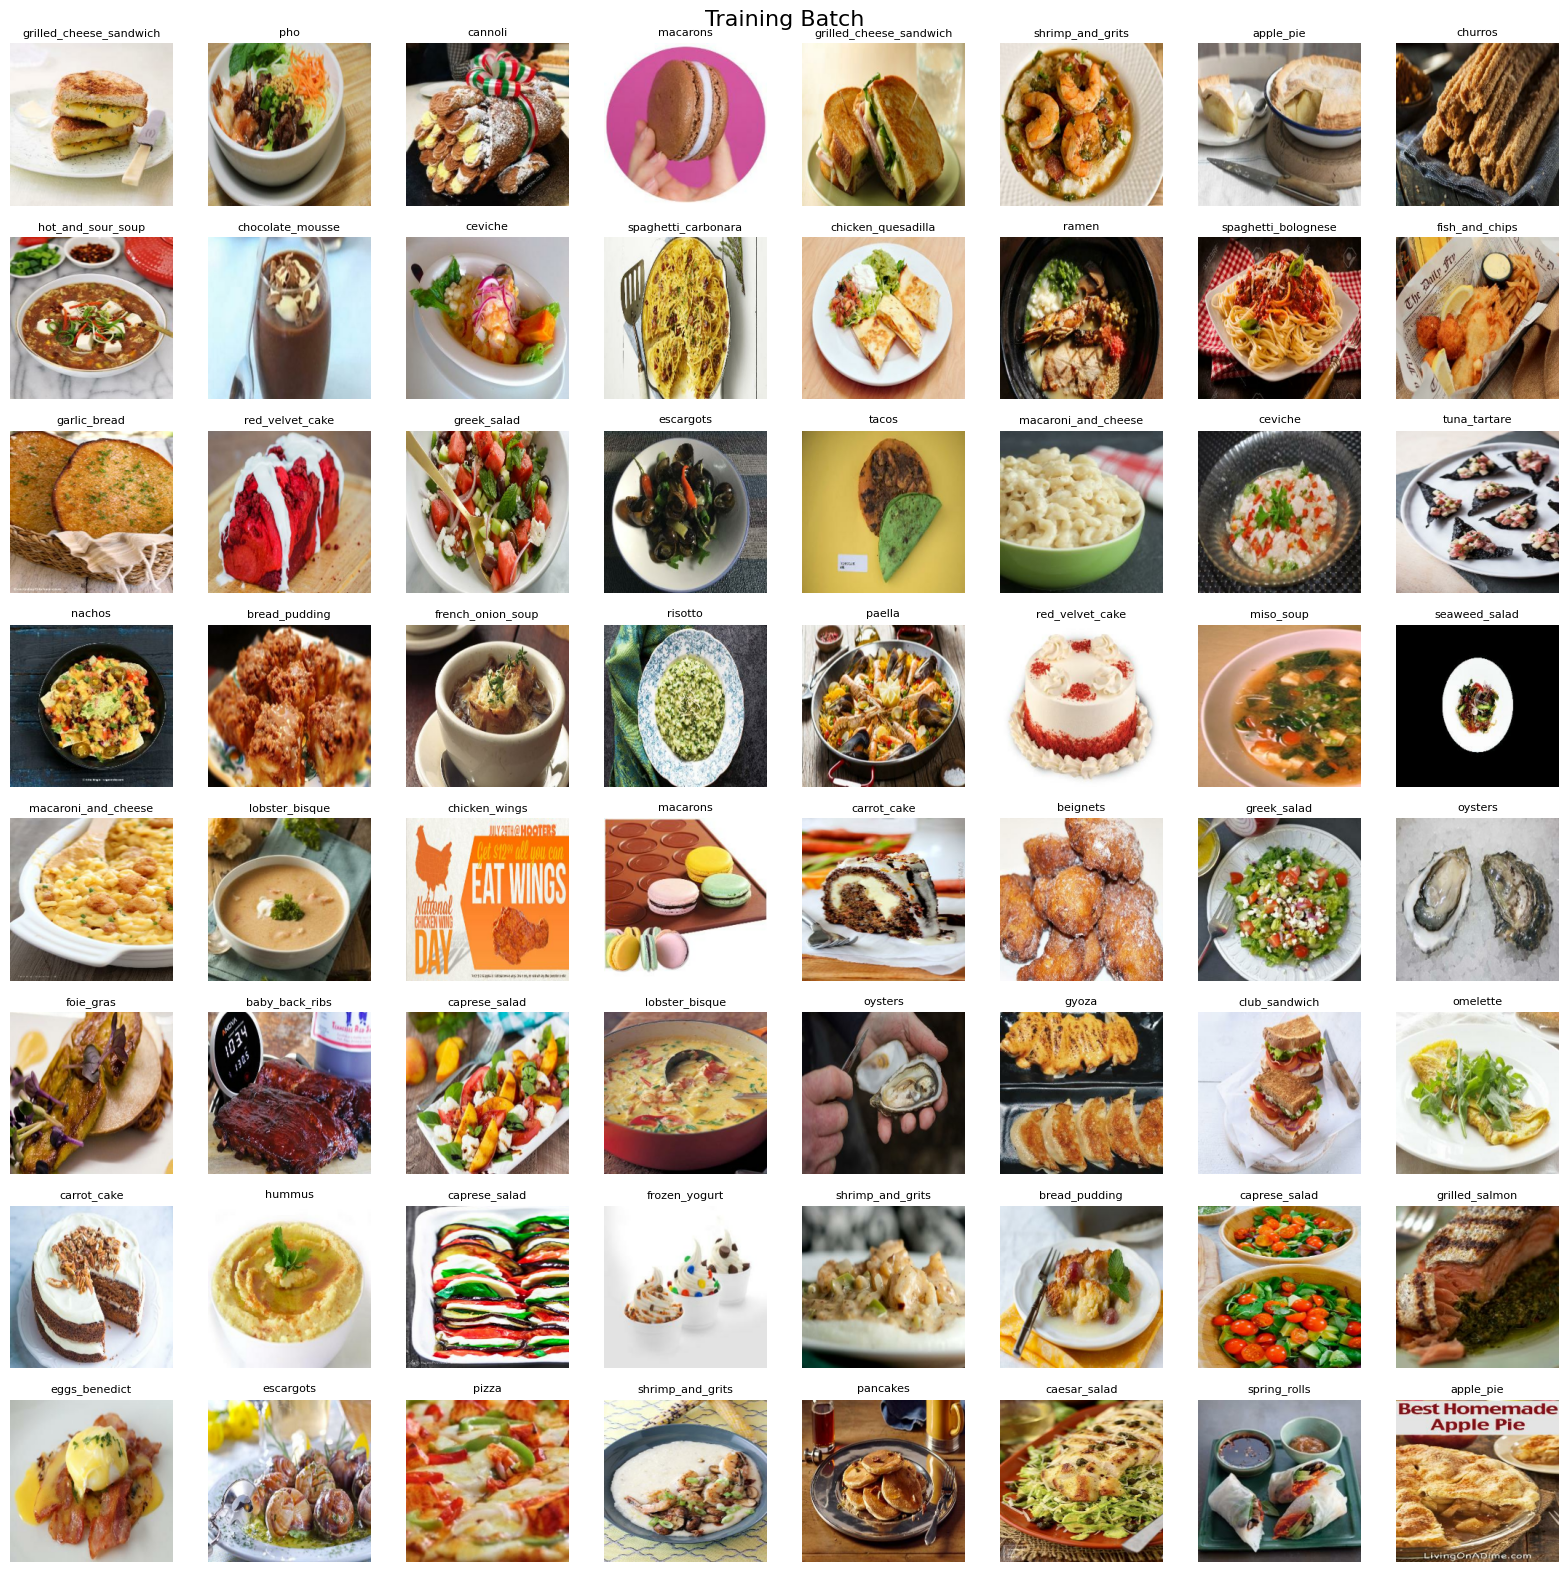

In [36]:
# train_ds_cutmix = create_dataset(train_paths_split, train_labels_split, augment=False)
# train_ds_cutmix = apply_cutmix(train_ds_cutmix)
show_batch(foodx_test_ds, classes)

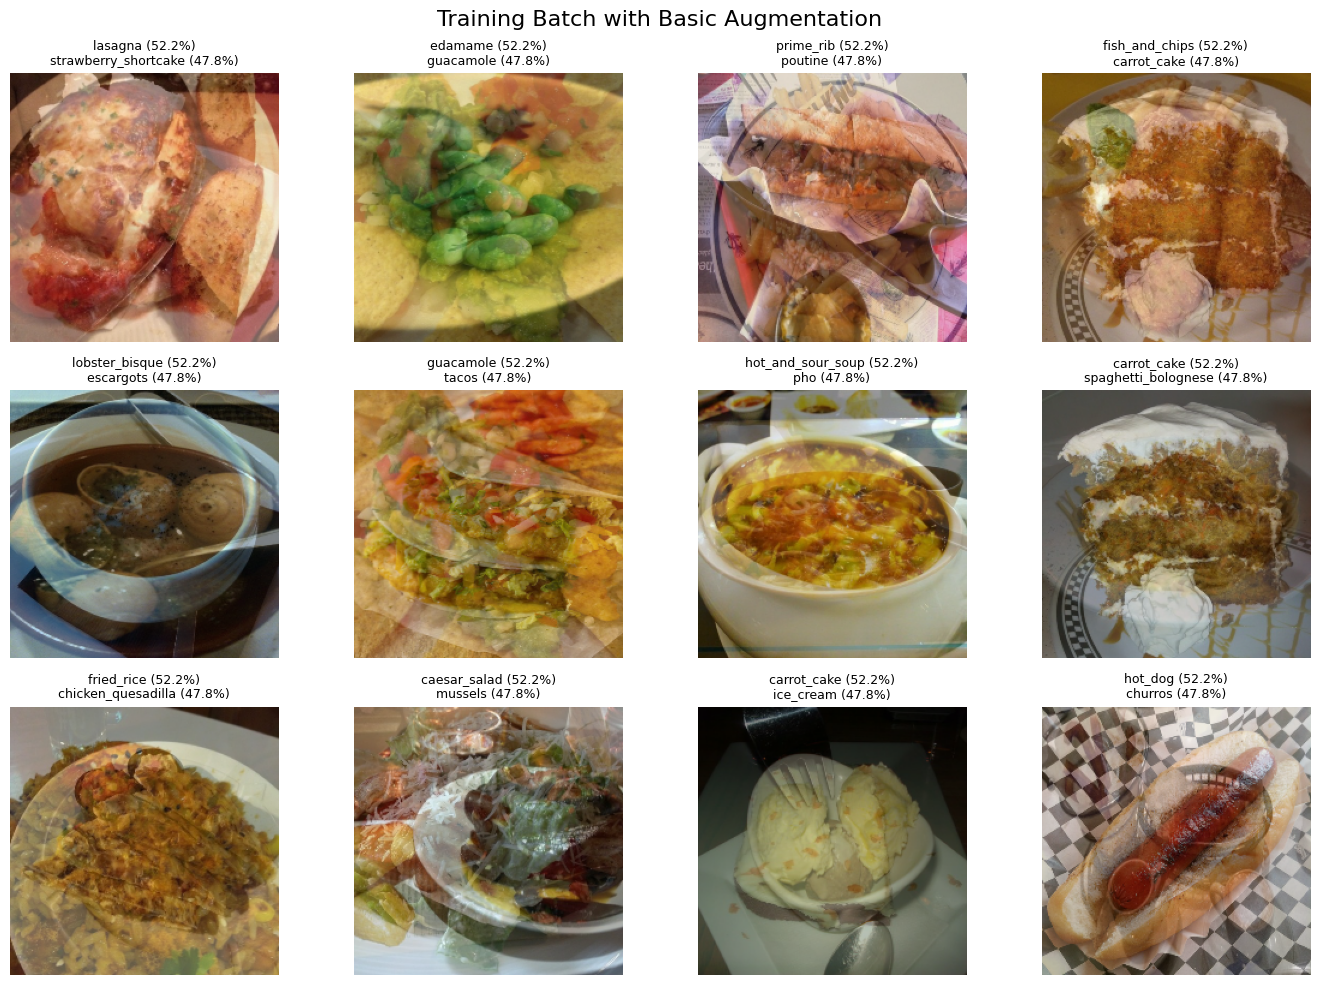

In [20]:
train_ds_mixup = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds_mixup = apply_mixup(train_ds_mixup)

show_batch_cutmix(train_ds_mixup, classes, title="Training Batch with Basic Augmentation")